# Time series modeling with seasonal ARIMA, Prophet and deep learning for PM10 level in Cracow, Poland

In a notebook I work with a measured PM10 data sampled every day from January 2000 to December 2018, at different measurement points located in Cracow, Poland. Data is open source.

In [1]:
import warnings
warnings.simplefilter("ignore")

import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import missingno as msno
import itertools

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller

# Getting PM10 data

Air quality data comes from http://powietrze.gios.gov.pl/pjp/archives. Unfortunetaly, there is no dedicated API for filtering out and downloading it easily in bulk. For this reason, I downloaded zip files for given year and extracted hundreds of excel files into one folder. To extract, load and transform PM10 data into python merged DataFrame I defined short function below.


In [2]:
# make sure the pwd contains excel files  
def get_data():
    """
    Read, extract and transform PM10 data stored in seperate excel files and return merged dataframe.
    """
    pm10=pd.DataFrame() #empty DataFrame
    for year in range(2000,2019):
        file=str(year)+'_PM10_24g.xlsx' # get file_name
        data=pd.read_excel(file,index_col=0) # open excel file
        cols=[x for x in data.columns if 'mpkrak' in x.lower()] # get stations in Cracow (they all start with 'mpkrak')
        data=data.iloc[2:][cols]
        pm10=pd.concat([data,pm10]) # concatenate exisiting DF with new one (add additional data)
        
    pm10.replace(',','.',regex=True, inplace = True) # replace ',' with '.'
    pm10.index=pd.to_datetime(pm10.index) # set datetime index
    pm10=pm10.astype(float) # transform object to float
    pm10.index.name='Time'
    return pm10

In [3]:
# getting data from excel files
pm10=get_data()
pm10.head(4)

,MpKrakBujaka,MpKrakBulwar,MpKrakOsPias,MpKrakTelime,MpKrakWadow,MpKrakZloRog,MpKrakowWIOSAKra6117,MpKrakowWIOSBuja6119,MpKrakowWIOSBulw6118,MpKrakowWIOSPrad6115,MpKrakowWSSEPrad6102,MpKrakowWSSERPod6113
Time,,,,,,,,,,,,
2018-01-01,NaN,65.79,53.70,NaN,28.74,67.87,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,NaN,75.57,59.69,NaN,48.78,78.60,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,NaN,22.84,20.75,NaN,18.78,25.70,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,20.58,23.97,19.13,13.39,19.51,22.86,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
pm10.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6940 entries, 2018-01-01 to 2000-12-31
Data columns (total 12 columns):
MpKrakBujaka            1418 non-null float64
MpKrakBulwar            1386 non-null float64
MpKrakOsPias            1075 non-null float64
MpKrakTelime            503 non-null float64
MpKrakWadow             660 non-null float64
MpKrakZloRog            1088 non-null float64
MpKrakowWIOSAKra6117    3603 non-null float64
MpKrakowWIOSBuja6119    1655 non-null float64
MpKrakowWIOSBulw6118    2122 non-null float64
MpKrakowWIOSPrad6115    2637 non-null float64
MpKrakowWSSEPrad6102    116 non-null float64
MpKrakowWSSERPod6113    151 non-null float64
dtypes: float64(12)
memory usage: 704.8 KB


# Exploratory Data Anaysis and Feature Engineering

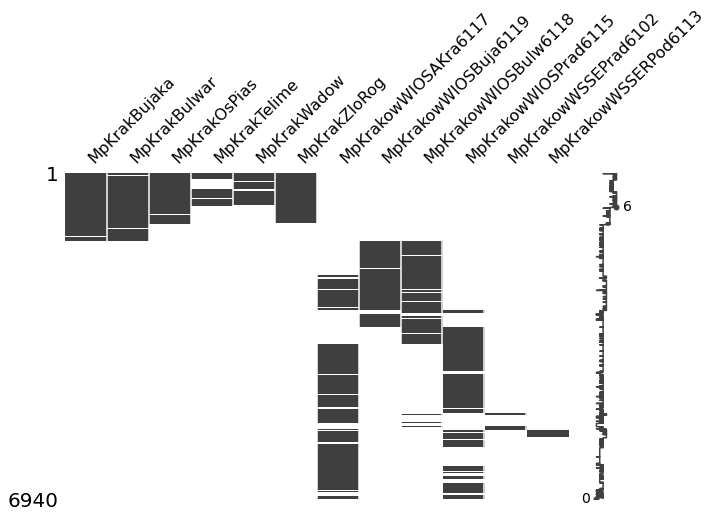

In [5]:
# plot missing values 
msno.matrix(pm10,figsize=(10, 6));

Because there are no stations without periods of missing values, I decided to calculate mean PM10 level of all stations in Cracow and use it for further analysis and modeling.

In [6]:
# calculate mean PM10 from all stations and fill NA
pm10['MeanPM10']=pm10.mean(axis=1)
pm10['MeanPM10']=pm10['MeanPM10'].fillna(pm10['MeanPM10'].bfill())
# create new columns with year, month and weekdays
pm10['Year']=pm10.index.year
pm10['Month']=pm10.index.month
pm10['Weekday']=pm10.index.weekday_name

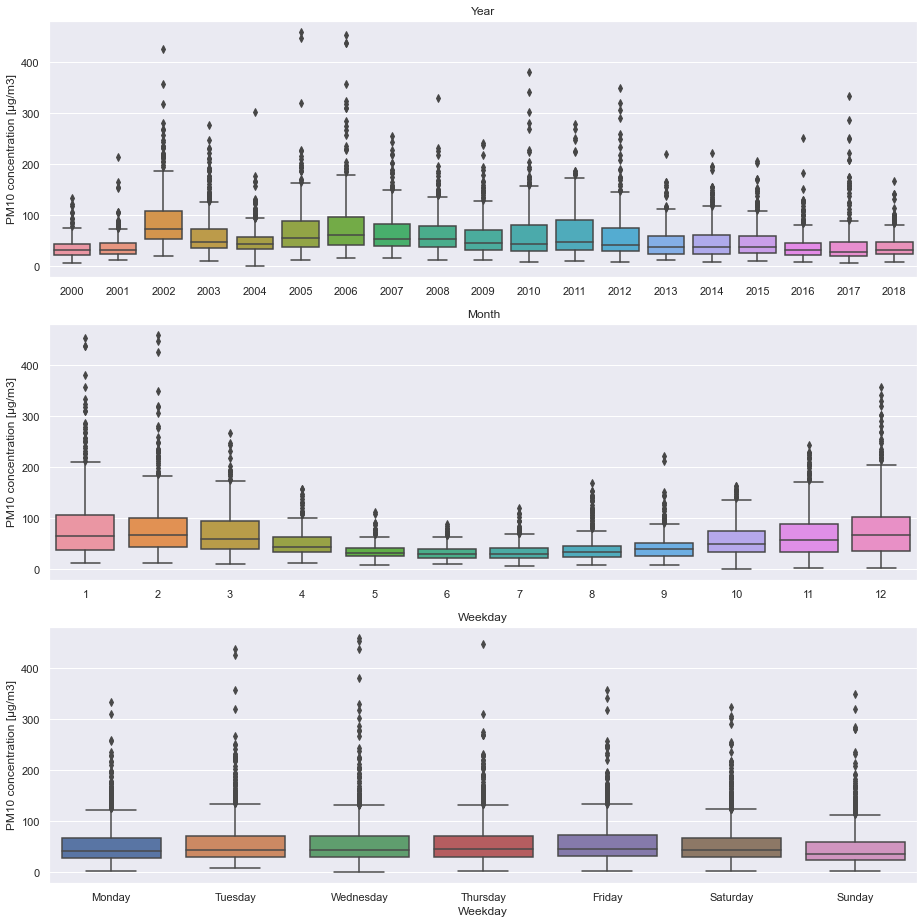

In [7]:
sns.set(rc={'figure.figsize':(15, 5)})
sns.set()
# Box plots for different time periods
cols=['Year','Month','Weekday']
fig,axes=plt.subplots(3,1,figsize=(13,13))
for col, ax in zip(cols,axes):
    sns.boxplot(y='MeanPM10',x=col,data=pm10,ax=ax)
    ax.set_title(col)
    ax.set_ylabel('PM10 concentration [µg/m3]')
    if ax!= axes[-1]:
        ax.set_xlabel('')
plt.tight_layout()

* Not surprisingly- the lowest PM10 level is observed during summers, the highest - during winters
* Average PM10 and variance tend to decrease over last years
* The least PM10-polluted day is Sunday and Monday, although the difference is slight
* Within all analysed time periods, there are strong positive outliers present, especially during winter months, what is most likely connected with weather conditions

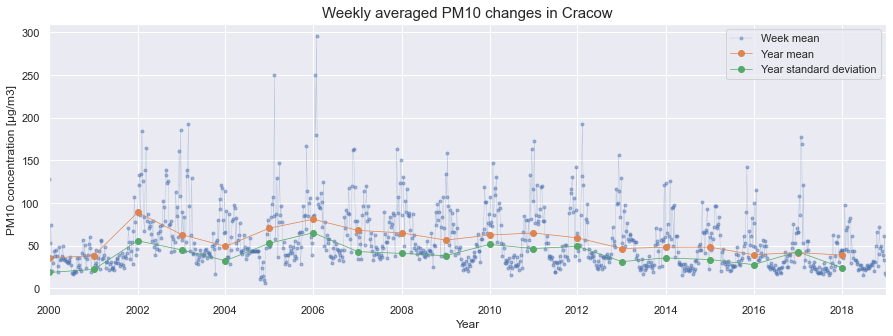

In [8]:
start='2000'
end='2019'
pm10_year=pm10.resample('Y').mean()
pm10_year_std=pm10.resample('Y').std()
pm10_week=pm10.resample('W').mean()

fig,ax=plt.subplots()

pm10_week.loc[start:end,'MeanPM10'].plot(marker='.',linewidth=0.3,ax=ax,alpha=0.45,label='Week mean')
pm10_year.loc[start:end,'MeanPM10'].plot(marker='o',linewidth=0.7,ax=ax,label='Year mean')
pm10_year_std.loc[start:end,'MeanPM10'].plot(marker='o',linewidth=0.7,ax=ax,label='Year standard deviation')

plt.title('Weekly averaged PM10 changes in Cracow',fontsize=15)
plt.ylabel('PM10 concentration [µg/m3]')
plt.xlabel('Year')
plt.legend()

There is a gradual, constant drop of PM10 level since 2006 with visible downward trend, for both mean and variance, aslo outliers seem to be less extreme. To make data more stationary, let's calculate log(PM10).

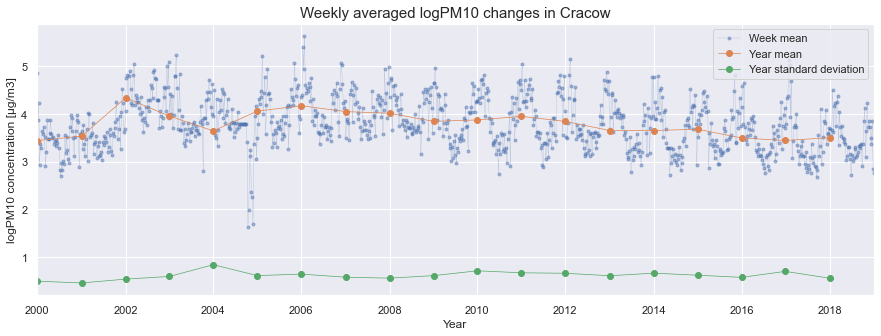

In [9]:
start='2000'
end='2019'
pm10log=pm10.iloc[:,:13].apply(lambda x:np.log(x))
pm10_year=pm10log.resample('Y').mean()
pm10_year_std=pm10log.resample('Y').std()
pm10_week=pm10log.resample('W').mean()

fig,ax=plt.subplots()

pm10_week.loc[start:end,'MeanPM10'].plot(marker='.',linewidth=0.3,ax=ax,alpha=0.45,label='Week mean')
pm10_year.loc[start:end,'MeanPM10'].plot(marker='o',linewidth=0.7,ax=ax,label='Year mean')
pm10_year_std.loc[start:end,'MeanPM10'].plot(marker='o',linewidth=0.7,ax=ax,label='Year standard deviation')

plt.title('Weekly averaged logPM10 changes in Cracow',fontsize=15)
plt.ylabel('logPM10 concentration [µg/m3]')
plt.xlabel('Year')
plt.legend()

To view seasonality, trend and random residual values, we can use the decomposition method. Residual variability is the data after removing the effects of the seasonality and trend.

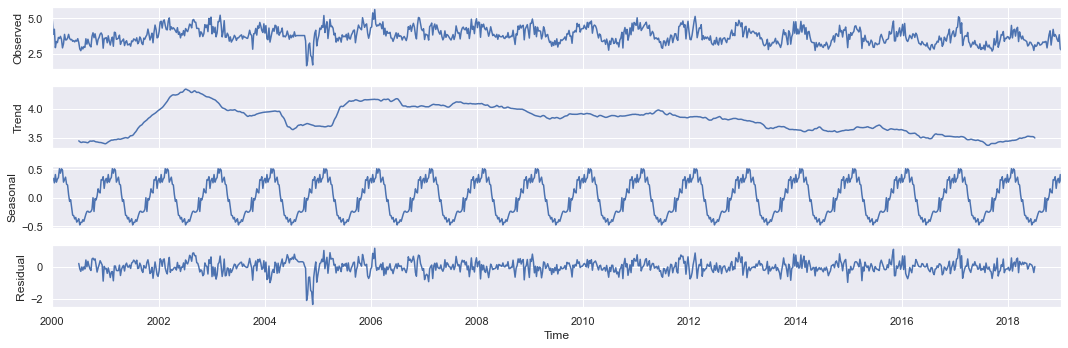

In [10]:
# use log(PM10) calculated in previous step
y=pm10_week['MeanPM10'].copy()

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The plot shows that the data has both trend and seasonality, what implies that data is not stationary. It validates assumption of ARIMA model I am going to use, hence I will have to make data stationary in next steps.

# Seasonal ARIMA model

ARIMA model is one of the most common methods used in time series forecasting. It stands for AutoregRessive Integrated Moving Average. There are three integers (p, d, q) which are used to parametrize ARIMA models and another three integers (P, D, Q) applied to the seasonal component of the time series.

* p/P is the auto-regressive part of the model (AR). It allows to incorporate the effect of past values into model.

* d/D is the integrated part of the model (I). This is the amount of differencing to apply to the time series (one of the ways to deal with non-stationarity).

* q/Q is the moving average part of the model (MA). It sets the error of model as a linear combination of the error values observed at previous time points in the past.

There are two usefull plots to determine ARIMA's params:

* ACF is an (complete) auto-correlation function which gives values of auto-correlation of any series with its lagged values.
* PACF is a partial auto-correlation function and instead of finding correlations of present with lags like ACF, it finds correlation of the residuals.

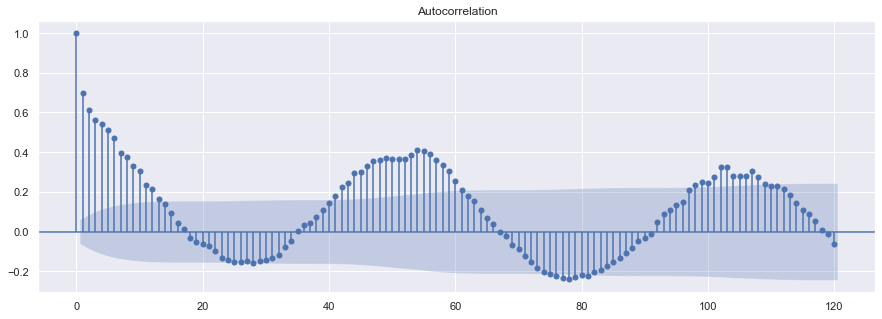

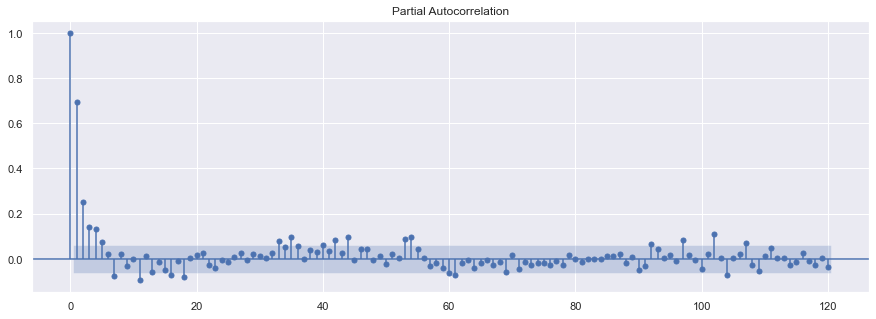

In [11]:
acf=plot_acf(y,lags=120)
pacf=plot_pacf(y,lags=120)

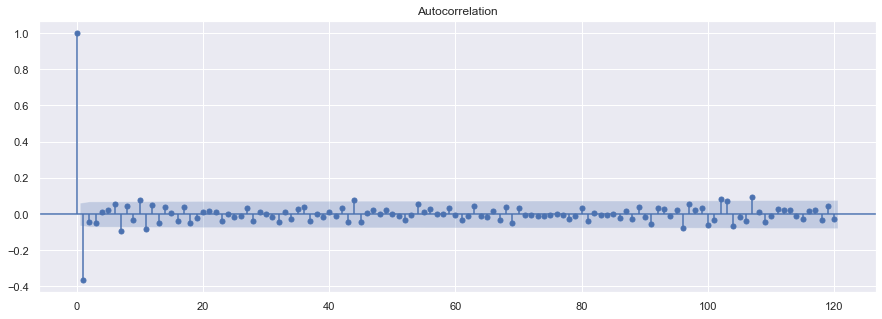

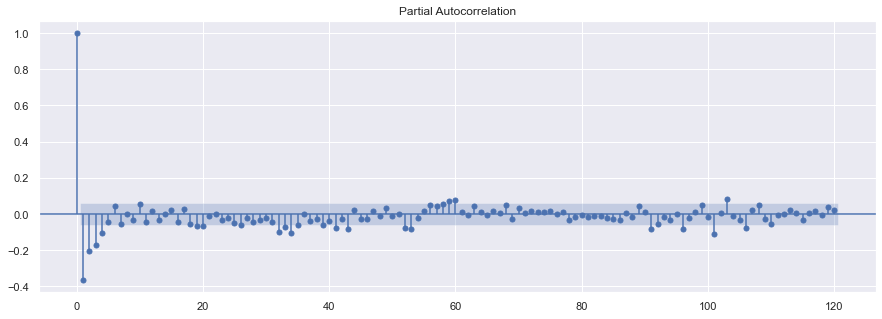

In [12]:
# let's apply first order differencing

y_diffs=y.diff(periods=1).dropna()
acf=plot_acf(y_diffs,lags=120)
pacf=plot_pacf(y_diffs,lags=120)

To confirm non-stationarity of data, I will use the Dickey-Fuller Hypothesis testing, where:
* Null Hypothesis: The series is not stationary.
* Alternative Hypothesis: The series is stationary.

In [13]:
from statsmodels.tsa.stattools import adfuller

test_result=adfuller(y_diffs)
print('ADF Statistic:{:.3f}'.format(test_result[0]))
print('p-value:{:.3f}'.format(test_result[1]))
print('Critical Values:')
for key, value in test_result[4].items():
    print('{}:{:.3f}'.format(key, value))

ADF Statistic:-14.872
p-value:0.000
Critical Values:
1%:-3.437
5%:-2.864
10%:-2.568


With the p-value <<0.05, I rejected the null hypothesis. Taking into account PACF and ACF plots and differencing, one can assume (p,d,q) to be (4,1,1). However different sets of (p,d,q) and (P,D,Q) should be also tested.

In [14]:
# ARIMA parameters 
p=range(4,5)
q=d=range(1,3)
pdq = list(itertools.product(p, d, q))

# seasonal ARIMA parameters 
P=D=Q=range(0,2)
PDQ = list(itertools.product(P,D,Q))
seasonal_pdq =[(x[0],x[1],x[2],52) for x in list(itertools.product(P,D,Q))] # 52 is the average number of weeks in a year, since data shows seasonality

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (4, 1, 2) x (0, 0, 1, 52)
SARIMAX: (4, 1, 2) x (0, 1, 0, 52)
SARIMAX: (4, 2, 1) x (0, 1, 1, 52)
SARIMAX: (4, 2, 1) x (1, 0, 0, 52)


In [15]:
def grid_search(y,pdq,seasonal_pdq):
    """
    Search for best model over range of combinations of seasonal ARIMA parameters.
    ---------------
    parameters:
    y : time series with datetime index
    pdq : ARIMA params
    seasonal_pdq : params of seasonal part of ARIMA
    ---------------
    return: parameters of model with lowest Akaike Information Critera (AIC) score
    
    """

    best_score=np.PINF
    best_model=None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

                results = mod.fit()
            
                if best_score>results.aic:
                    best_score=results.aic
                    best_model='ARIMA{}x{}'.format(param, param_seasonal)

                print('ARIMA{}x{} - AIC:{:.1f}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('--'*30)
    print('Best model: {}, AIC {:.1f}'.format(best_model,best_score))

In [16]:
# run grid search over params
grid_search(y,pdq,seasonal_pdq)

ARIMA(4, 1, 1)x(0, 0, 0, 52) - AIC:846.3
ARIMA(4, 1, 1)x(0, 0, 1, 52) - AIC:821.5
ARIMA(4, 1, 1)x(0, 1, 0, 52) - AIC:1417.2
ARIMA(4, 1, 1)x(0, 1, 1, 52) - AIC:807.7
ARIMA(4, 1, 1)x(1, 0, 0, 52) - AIC:820.0
ARIMA(4, 1, 1)x(1, 0, 1, 52) - AIC:822.0
ARIMA(4, 1, 1)x(1, 1, 0, 52) - AIC:1097.0
ARIMA(4, 1, 1)x(1, 1, 1, 52) - AIC:826.3


C:\Users\gorcz\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 1, 2)x(0, 0, 0, 52) - AIC:850.1
ARIMA(4, 1, 2)x(0, 0, 1, 52) - AIC:822.1
ARIMA(4, 1, 2)x(0, 1, 0, 52) - AIC:1414.2


C:\Users\gorcz\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 1, 2)x(0, 1, 1, 52) - AIC:800.5
ARIMA(4, 1, 2)x(1, 0, 0, 52) - AIC:821.0


C:\Users\gorcz\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 1, 2)x(1, 0, 1, 52) - AIC:823.0
ARIMA(4, 1, 2)x(1, 1, 0, 52) - AIC:1096.9


C:\Users\gorcz\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 1, 2)x(1, 1, 1, 52) - AIC:823.2
ARIMA(4, 2, 1)x(0, 0, 0, 52) - AIC:855.2
ARIMA(4, 2, 1)x(0, 0, 1, 52) - AIC:826.9
ARIMA(4, 2, 1)x(0, 1, 0, 52) - AIC:1489.0
ARIMA(4, 2, 1)x(0, 1, 1, 52) - AIC:858.0
ARIMA(4, 2, 1)x(1, 0, 0, 52) - AIC:827.8
ARIMA(4, 2, 1)x(1, 0, 1, 52) - AIC:829.7
ARIMA(4, 2, 1)x(1, 1, 0, 52) - AIC:1158.9
ARIMA(4, 2, 1)x(1, 1, 1, 52) - AIC:876.9
ARIMA(4, 2, 2)x(0, 0, 0, 52) - AIC:856.0
ARIMA(4, 2, 2)x(0, 0, 1, 52) - AIC:828.2
ARIMA(4, 2, 2)x(0, 1, 0, 52) - AIC:1433.9


C:\Users\gorcz\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 2, 2)x(0, 1, 1, 52) - AIC:818.6
ARIMA(4, 2, 2)x(1, 0, 0, 52) - AIC:827.7


C:\Users\gorcz\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 2, 2)x(1, 0, 1, 52) - AIC:829.5


C:\Users\gorcz\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 2, 2)x(1, 1, 0, 52) - AIC:1115.0


C:\Users\gorcz\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 2, 2)x(1, 1, 1, 52) - AIC:842.8
------------------------------------------------------------
Best model: ARIMA(4, 1, 2)x(0, 1, 1, 52), AIC 800.5


In [17]:
# make model with best set of params
sarima = sm.tsa.statespace.SARIMAX(y[:'2017'],
                                            order=(4,1,2),
                                            seasonal_order=(0, 1, 1,52),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
results = sarima.fit()

C:\Users\gorcz\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


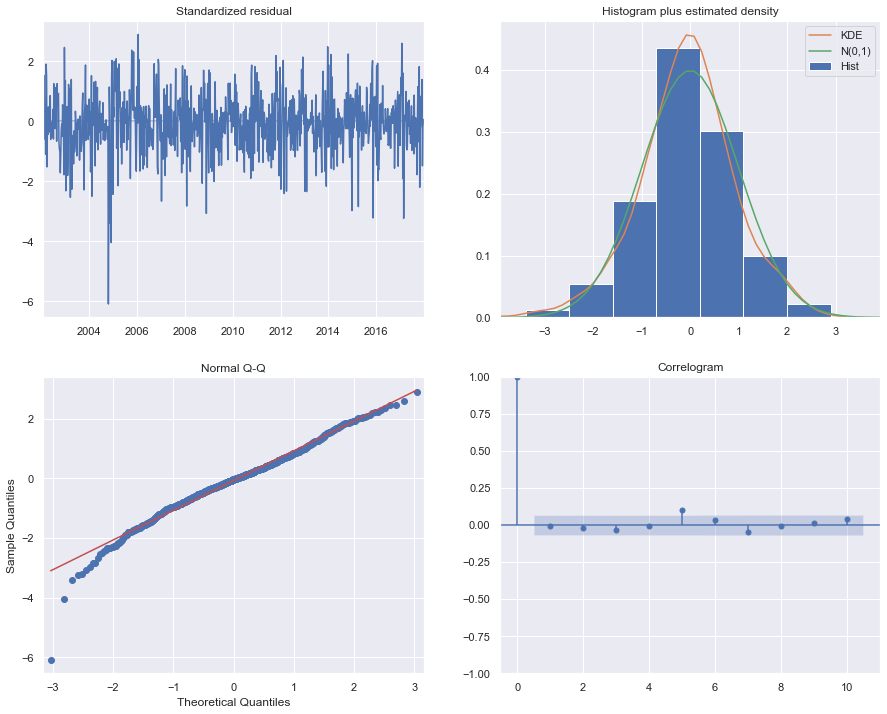

In [18]:
# run diagnostics to check for unusual behaviour
results.plot_diagnostics(figsize=(15, 12))
plt.show()

The residuals are uncorrelated and normally distributed with zero-mean, what indicates good quality of the model (it can't be significantly imporved further).

In [19]:
# get predicted values for trained data
pred = results.get_prediction(start=pd.to_datetime('2010-01-03'), dynamic=False)
pred_ci = pred.conf_int()

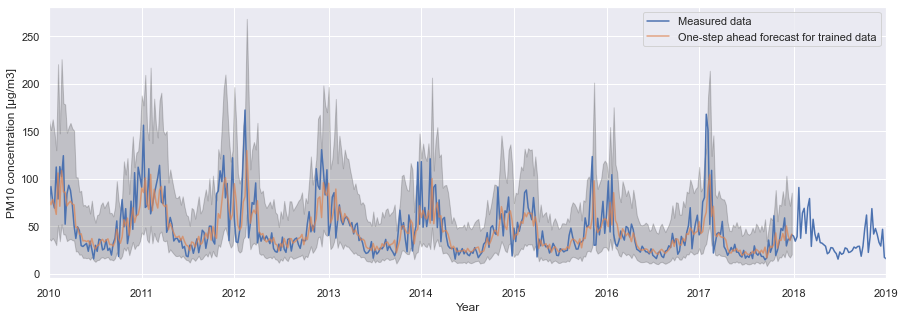

In [20]:
plt.figure(figsize=(15,5))
ax = np.exp(y.loc['2010-01-03':]).plot(label='Measured data')
np.exp(pred.predicted_mean).plot(ax=ax, label='One-step ahead forecast for trained data', alpha=.7)

ax.fill_between(pred_ci.index,
                np.exp(pred_ci.iloc[:, 0]),
                np.exp(pred_ci.iloc[:, 1]), color='k', alpha=.2)

ax.set_xlabel('Year')
ax.set_ylabel('PM10 concentration [µg/m3]')
plt.legend()

plt.show()

In [21]:
# get forecast 2 years ahead in future
pred_uc = results.get_forecast(steps=104)

# get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

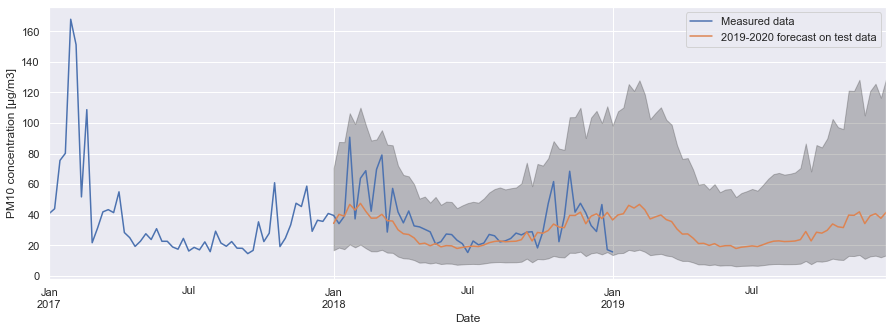

In [22]:
ax = np.exp(y.loc['2017':]).plot(label='Measured data')
np.exp(pred_uc.predicted_mean).plot(ax=ax, label='2019-2020 forecast on test data')
ax.fill_between(pred_ci.index,
                np.exp(pred_ci.iloc[:, 0]),
                np.exp(pred_ci.iloc[:, 1]), color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('PM10 concentration [µg/m3]')

plt.legend()
plt.show()

Calculate RMSE for test 2018 data, which was not used to build ARIMA model.

In [23]:
from sklearn.metrics import mean_squared_error

y_true=y.loc['2018-01-07':'2018-12-30']
y_hat=pred_uc.predicted_mean.loc[:'2018-12-30']
print('SARIMA RMSE is {:.2f}'.format(mean_squared_error(np.exp(y_true),np.exp(y_hat),squared=False)))

SARIMA RMSE is 14.04


# Facebook Prophet model

Prophet is forecasting tool released by Facebook in 2017, designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It much more automated and doesn't involve extensive hyperparameters tuning as compared with ARIMA.

In [24]:
from fbprophet import Prophet

In [25]:
# transform data into format that fbprophet accepts
fb_pm10=y.reset_index().rename(columns={'Time': 'ds', 'MeanPM10': 'y'})

In [26]:
# create model and fit it 
fb_model = Prophet(interval_width=0.95,yearly_seasonality=True)
fb_model.fit(fb_pm10.loc[:939])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [27]:
# get forecast 2 years ahead in future
future_dates = fb_model.make_future_dataframe(periods=104, freq='W')
forecast = fb_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1039,2019-12-01,3.631529,2.876786,4.394527
1040,2019-12-08,3.657643,2.873268,4.490106
1041,2019-12-15,3.627933,2.853154,4.418536
1042,2019-12-22,3.590605,2.815284,4.341910
1043,2019-12-29,3.594283,2.792889,4.416818


<Figure size 1080x360 with 0 Axes>

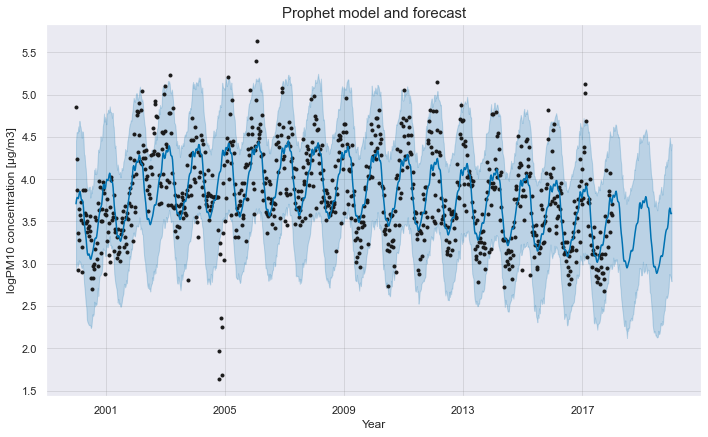

In [28]:
plt.figure()
fb_model.plot(forecast, xlabel = 'Year', ylabel = 'logPM10 concentration [µg/m3]')
plt.title('Prophet model and forecast',fontsize=15);

Let's use Prophet Model to inspect trends.

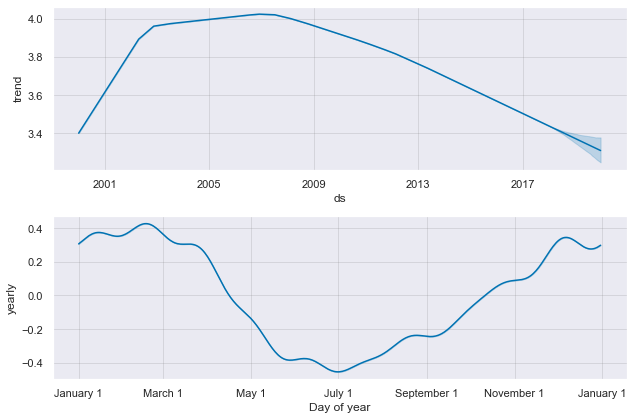

In [29]:
fb_model.plot_components(forecast);

In [30]:
# let's check RMSE for test set
y_hat_fb=forecast.loc[940:991]['yhat']
print('Prophet RMSE is {:.2f}'.format(mean_squared_error(np.exp(y_true),np.exp(y_hat_fb),squared=False)))

Prophet RMSE is 13.69


# First conclusions and lessons learned

Prophet's RMSE is slighlty lower than ARIMA's, model is also easier and faster to build and train. Both models are generalized, they can't predict weeks with anomalously high PM10 levels. It justified and makes sense since univariate time series model is udoubtetly insufficient to model PM10 as it's not exclusively function of time. 

Higher values that weren't predicted by either of models are single events which are impossible to model without additional data (say temperature or wind data). Confidece interval gets wider as forecast time increases, what's intuitively understandable. To descrease model bias, one would have to incorporate external data sources into model (for example SARIMA with exogenous variables). It seems the right way to follow.

# LSTM and GRU coming soon...

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers